In [1]:
import json
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_context('paper', font_scale=1.25)
sns.set_style('whitegrid')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'DejaVu Sans']
plt.rcParams['font.family'] = 'sans-serif'

# Webis colours
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[
    '#90d7de',
    '#9ed977',
    '#ffab9e',
    '#d6acfa',
    '#ffc640',
    '#68b4c2',
    '#62ba61',
    '#ff6f52',
    '#bb86f3',
    '#e8a01d',
])

os.makedirs('../data/eval-figures', exist_ok=True)

In [3]:
# from collections import defaultdict
# import os
# import sys
# 
# import tira.rest_api_client
# from tqdm import tqdm
# 
# tira_client = tira.rest_api_client.Client(failsave_retries=1, failsave_max_delay=1)
# task = 'generative-ai-authorship-verification-panclef-2024'
# 
# task_datasets = [d for d in tira_client.datasets(task).keys()
#                  if d != 'pan24-generative-authorship-news-check-20240523-test' and not d.endswith('-training')]
# 
# evaluations = []
# for d in tqdm(task_datasets, desc='Retrieving evaluations'):
#     e = tira_client.evaluations(task, d)
#     if e.empty:
#         continue
#     evaluations.append(e[['dataset', 'team', 'software']])
# evaluations = pd.concat(evaluations).dropna().drop_duplicates()
# 
# teams_to_softwares = defaultdict(set)
# for _, r in evaluations.iterrows():
#     teams_to_softwares[r['team']].add(str(r['software']))
# with open('teams-to-systems.json', 'w') as f: json.dump({k: sorted(v) for k, v in teams_to_softwares.items()}, f, ensure_ascii=False, indent=2)
# 
# 
# # Block verbose output
# tira.rest_api_client.tqdm = lambda *args, **_: args
# tira.rest_api_client.print = lambda *args: None
# try:
#     evaluation_scores = defaultdict(lambda: defaultdict(dict))
#     for _, r in tqdm(evaluations.iterrows(), desc='Downloading runs'):
#         dir = tira_client.download_evaluation(task, r['dataset'], r['software'], r['team'])
#         if not os.path.isfile(os.path.join(dir, 'evaluation.json')):
#             print(f'Failed to download {r["team"]}/{r["software"]}/{r["dataset"]}', file=sys.stderr)
#             continue
#         with open(os.path.join(dir, 'evaluation.json')) as f:
#             evaluation_scores[r['team']][r['software']][r['dataset']] = json.load(f)
#             
#     with open('evaluation-scores.json', 'w') as f: json.dump(evaluation_scores, f, ensure_ascii=False, indent=2)
# finally:
#     # Unscrew output muffler
#     tira.rest_api_client.tqdm = tqdm
#     del tira.rest_api_client.print

In [4]:
teams_to_systems = json.load(open('teams-to-systems.json'))
datasets = {
    # dataset_name: (category, prefix, suffix)
    'pan24-generative-authorship-test-20240502-test': ('main', '', ''),
    'pan24-generative-authorship-test-b-20240506-test': ('cross-topic', '', '-cross-topic'),
    'pan24-generative-authorship-news-test-c-20240506-test': ('unicode-full', '', '-unicode-full'),
    'pan24-generative-authorship-news-test-d-20240506-test': ('unicode-half', '', '-unicode-half'),
    # 'pan24-generative-authorship-news-test-e-20240506-test': ('german', '', '-german'),          # German was mixed into main dataset
    'pan24-generative-authorship-news-test-f-20240514-test': ('paraphrase', '', '-paraphrase'),
    'pan24-generative-authorship-news-test-g-20240529-test': ('contrastive', '', ''),              # suffix already part of the name
    'pan24-generative-authorship-news-test-h-20240521-test': ('short', '', '-short'),
    'pan24-generative-authorship-eloquent-20240523-test': ('eloquent', 'eloquent-', ''),
}

df_ = []
df_micro_mean_ = []

def _ensure_key_order(d):
    order = {
        'roc-auc': 0,
        'brier': 1,
        'c@1': 2,
        'f1': 3,
        'f05u': 4,
        'mean': 5,
    }
    return {k: v for k, v in sorted(d.items(), key=lambda x: order[x[0]])}
    
evaluation_scores = json.load(open('evaluation-scores.json', 'r'))
for team, systems in teams_to_systems.items():
    for s in systems:
        if team == 'baseline' and not s.startswith('baseline-'):
            continue
        row_base = {'system': s, 'team': team if team != 'baseline' else s}
        for d, (dname, pre, suff) in datasets.items():
            df_micro_mean_.append({
                **row_base,
                'category': dname,
                **_ensure_key_order({k:v for k, v in evaluation_scores[team].get(s, {}).get(d, {}).items() if k != '_sources'})
            })
            df_.extend(
                {
                    **row_base,
                    'dataset': ''.join((pre, src, suff)),
                    'category': dname,
                    **_ensure_key_order(evaluation_scores[team][s][d]['_sources'][src])
                } for src in evaluation_scores[team].get(s, {}).get(d, {}).get('_sources', [])
            )

df_micro_mean_ = pd.DataFrame(df_micro_mean_)
df_micro_mean_.set_index(['team', 'system', 'category'], inplace=True)

df_ = pd.DataFrame(df_)

team_sys_ = df_[['team', 'system']].drop_duplicates()
src_ = df_[['category', 'dataset']].drop_duplicates()
df_.set_index(['team', 'system', 'category', 'dataset'], inplace=True)

# Fill missing values for fairness
fill_ = []
for _, ts in team_sys_.iterrows():
    if ts['team'].startswith('baseline-'):
        continue
    for _, s in src_.iterrows():
        idx = (ts['team'], ts['system'], s['category'], s['dataset'])
        if idx not in df_.index:
            f = {k: v for k, v in zip(df_.index.names, idx)}
            f.update({c: np.float64(None) for c in df_.columns})
            fill_.append(f)
if fill_:
    df_ = pd.concat([df_, pd.DataFrame.from_dict(fill_).set_index(df_.index.names)])

### Micro Mean (All)

In [5]:
df_micro_mean_

roc-auc  brier    c@1  \
team                system              category                              
baseline-binoculars baseline-binoculars main            0.972  0.957  0.966   
                                        cross-topic     0.970  0.955  0.962   
                                        unicode-full    0.860  0.855  0.837   
                                        unicode-half    0.298  0.462  0.320   
                                        paraphrase      0.845  0.864  0.841   
...                                                       ...    ...    ...   
ds-gtpan            nervous-blur        unicode-half      NaN    NaN    NaN   
                                        paraphrase        NaN    NaN    NaN   
                                        contrastive     0.490  0.482  0.482   
                                        short           0.494  0.482  0.482   
                                        eloquent        0.727  0.725  0.725   

                                                         f1   f05u   mean  
team                system              category                           
baseline-binoculars baseline-binoculars main          0.964  0.965  0.965  
                                        cross-topic   0.961  0.959  0.962  
                                        unicode-full  0.831  0.822  0.841  
                                        unicode-half  0.311  0.319  0.342  
                                        paraphrase    0.840  0.828  0.844  
...                                                     ...    ...    ...  
ds-gtpan            nervous-blur        unicode-half    NaN    NaN    NaN  
                                        paraphrase      NaN    NaN    NaN  
                                        contrastive   0.547  0.496  0.499  
                                        short         0.596  0.518  0.514  
                                        eloquent      0.748  0.706  0.726  

[920 rows x 6 columns]

### Macro Mean (All)

In [6]:
df_

roc-auc  \
team                system              category     dataset                                                
baseline-binoculars baseline-binoculars main         alpaca-7b                                      0.976   
                                                     bigscience-bloomz-7b1                          0.993   
                                                     gemini-pro                                     1.000   
                                                     gemini-pro-high-temperature                    1.000   
                                                     gpt-3.5-turbo-0125                             0.984   
...                                                                                                   ...   
ds-gtpan            nervous-blur        unicode-half gpt-4-turbo-preview-unicode-half                 NaN   
                                                     meta-llama-llama-2-70b-chat-hf-unicode-half      NaN   
                                                     meta-llama-llama-2-7b-chat-hf-unicode-half       NaN   
                                        paraphrase   gemini-pro-paraphrase-paraphrase                 NaN   
                                                     gpt-4-turbo-preview-paraphrase-paraphrase        NaN   

                                                                                                  brier  \
team                system              category     dataset                                              
baseline-binoculars baseline-binoculars main         alpaca-7b                                    0.967   
                                                     bigscience-bloomz-7b1                        0.967   
                                                     gemini-pro                                   0.983   
                                                     gemini-pro-high-temperature                  0.980   
                                                     gpt-3.5-turbo-0125                           0.963   
...                                                                                                 ...   
ds-gtpan            nervous-blur        unicode-half gpt-4-turbo-preview-unicode-half               NaN   
                                                     meta-llama-llama-2-70b-chat-hf-unicode-half    NaN   
                                                     meta-llama-llama-2-7b-chat-hf-unicode-half     NaN   
                                        paraphrase   gemini-pro-paraphrase-paraphrase               NaN   
                                                     gpt-4-turbo-preview-paraphrase-paraphrase      NaN   

                                                                                                    c@1  \
team                system              category     dataset                                              
baseline-binoculars baseline-binoculars main         alpaca-7b                                    0.979   
                                                     bigscience-bloomz-7b1                        0.978   
                                                     gemini-pro                                   1.000   
                                                     gemini-pro-high-temperature                  0.996   
                                                     gpt-3.5-turbo-0125                           0.974   
...                                                                                                 ...   
ds-gtpan            nervous-blur        unicode-half gpt-4-turbo-preview-unicode-half               NaN   
                                                     meta-llama-llama-2-70b-chat-hf-unicode-half    NaN   
                                                     meta-llama-llama-2-7b-chat-hf-unicode-half     NaN   
                                        paraphrase   gemini-pro-paraphrase-paraphrase               NaN   
    

### Final System Selection (by Best Micro Mean Effectiveness on Main Dataset Category)

In [7]:
df_systems_final = df_micro_mean_.query('category == "main"').groupby('team')['mean'].idxmax().dropna()
df_systems_final = df_micro_mean_.loc[df_systems_final].sort_values('mean', ascending=False)
df_systems_final = df_systems_final.reset_index()[['team', 'system']]
df_systems_final.set_index(['team', 'system'], inplace=True)
df_systems_final

,
team,system
marsan,staff-trunk
iimasnlp,final-run4-gnnllm_llmft_stylofeat-partitionB
you-shun-you-de,charitable-mole_v3
lam,blistering-moss
jaha,greasy-chest
aida,corporate-burn
drocks,muffled-stock
verification-team,merciless-lease
baselineavengers,svm


### Dataframes Filtered

In [8]:
def _fill_nan_with_mean(df, idx_group_slice):
    """Fill NaN values with mean value of all systems."""
    df_mean = df.groupby(df.index.names[idx_group_slice]).mean().round(3)
    df_nan = df[df.isna().any(axis=1)]
    df = df.copy()
    for i, _ in df_nan.iterrows():
        df.loc[i] = df_mean.loc[i[idx_group_slice]]
    return df, df_nan.index

In [9]:
df = df_.loc[df_systems_final.index.get_level_values(0), df_systems_final.index.get_level_values(1), :]
df, df_nan = _fill_nan_with_mean(df, slice(-2, None))
df

roc-auc  brier  \
team        system      category dataset                                       
marsan      staff-trunk main     alpaca-7b                      1.000  0.995   
                                 bigscience-bloomz-7b1          1.000  0.993   
                                 gemini-pro                     1.000  0.999   
                                 gemini-pro-high-temperature    1.000  0.997   
                                 gpt-3.5-turbo-0125             1.000  0.997   
...                                                               ...    ...   
lm-detector detector    eloquent eloquent-chatgpt35             0.821  0.781   
                                 eloquent-gptsw3                0.539  0.615   
                                 eloquent-reindeer-mistral      0.594  0.677   
                                 eloquent-reindeer-poro         0.417  0.531   
                                 eloquent-verbanex-ai           0.600  0.677   

                                                                c@1     f1  \
team        system      category dataset                                     
marsan      staff-trunk main     alpaca-7b                    0.995  0.995   
                                 bigscience-bloomz-7b1        1.000  1.000   
                                 gemini-pro                   1.000  1.000   
                                 gemini-pro-high-temperature  0.996  0.997   
                                 gpt-3.5-turbo-0125           1.000  1.000   
...                                                             ...    ...   
lm-detector detector    eloquent eloquent-chatgpt35           0.688  0.762   
                                 eloquent-gptsw3              0.458  0.286   
                                 eloquent-reindeer-mistral    0.486  0.421   
                                 eloquent-reindeer-poro       0.344  0.211   
                                 eloquent-verbanex-ai         0.486  0.471   

                                                               f05u   mean  
team        system      category dataset                                    
marsan      staff-trunk main     alpaca-7b                    0.998  0.996  
                                 bigscience-bloomz-7b1        1.000  0.999  
                                 gemini-pro                   1.000  1.000  
                                 gemini-pro-high-temperature  0.999  0.998  
                                 gpt-3.5-turbo-0125           1.000  0.999  
...                                                             ...    ...  
lm-detector detector    eloquent eloquent-chatgpt35           0.656  0.742  
                                 eloquent-gptsw3              0.349  0.449  
                                 eloquent-reindeer-mistral    0.476  0.531  
                                 eloquent-reindeer-poro       0.233  0.347  
                                 eloquent-verbanex-ai         0.444  0.536  

[2958 rows x 6 columns]

In [10]:
print('Filled NaN values:')
df.loc[df_nan].reset_index()[['team', 'system', 'category', 'dataset']].drop_duplicates().set_index(['team', 'system', 'category', 'dataset'])

Filled NaN values:


Empty DataFrame
Columns: []
Index: [(iimasnlp, final-run4-gnnllm_llmft_stylofeat-partitionB, short, alpaca-7b-short), (iimasnlp, final-run4-gnnllm_llmft_stylofeat-partitionB, short, bigscience-bloomz-7b1-short), (iimasnlp, final-run4-gnnllm_llmft_stylofeat-partitionB, short, gemini-pro-short), (iimasnlp, final-run4-gnnllm_llmft_stylofeat-partitionB, short, gemini-pro-high-temperature-short), (iimasnlp, final-run4-gnnllm_llmft_stylofeat-partitionB, short, gemini-pro-paraphrase-short), (iimasnlp, final-run4-gnnllm_llmft_stylofeat-partitionB, short, gpt-3.5-turbo-0125-short), (iimasnlp, final-run4-gnnllm_llmft_stylofeat-partitionB, short, gpt-4-turbo-preview-short), (iimasnlp, final-run4-gnnllm_llmft_stylofeat-partitionB, short, gpt-4-turbo-preview-german-short), (iimasnlp, final-run4-gnnllm_llmft_stylofeat-partitionB, short, gpt-4-turbo-preview-paraphrase-short), (iimasnlp, final-run4-gnnllm_llmft_stylofeat-partitionB, short, meta-llama-llama-2-13b-chat-hf-contrastive-0.1-short), (iimasnlp, final-run4-gnnllm_llmft_stylofeat-partitionB, short, meta-llama-llama-2-13b-chat-hf-contrastive-0.6-short), (iimasnlp, final-run4-gnnllm_llmft_stylofeat-partitionB, short, meta-llama-llama-2-70b-chat-hf-short), (iimasnlp, final-run4-gnnllm_llmft_stylofeat-partitionB, short, meta-llama-llama-2-7b-chat-hf-short), (iimasnlp, final-run4-gnnllm_llmft_stylofeat-partitionB, short, mistralai-mistral-7b-instruct-v0.2-short), (iimasnlp, final-run4-gnnllm_llmft_stylofeat-partitionB, short, mistralai-mixtral-8x7b-instruct-v0.1-short), (iimasnlp, final-run4-gnnllm_llmft_stylofeat-partitionB, short, qwen-qwen1.5-72b-chat-8bit-short), (iimasnlp, final-run4-gnnllm_llmft_stylofeat-partitionB, short, text-bison-002-short), (iimasnlp, final-run4-gnnllm_llmft_stylofeat-partitionB, short, text-bison-002-german-short), (iimasnlp, final-run4-gnnllm_llmft_stylofeat-partitionB, short, vicgalle-gpt2-open-instruct-v1-short), (huangbaijian, bitter-metaphor, short, alpaca-7b-short), (huangbaijian, bitter-metaphor, short, bigscience-bloomz-7b1-short), (huangbaijian, bitter-metaphor, short, gemini-pro-short), (huangbaijian, bitter-metaphor, short, gemini-pro-high-temperature-short), (huangbaijian, bitter-metaphor, short, gemini-pro-paraphrase-short), (huangbaijian, bitter-metaphor, short, gpt-3.5-turbo-0125-short), (huangbaijian, bitter-metaphor, short, gpt-4-turbo-preview-short), (huangbaijian, bitter-metaphor, short, gpt-4-turbo-preview-german-short), (huangbaijian, bitter-metaphor, short, gpt-4-turbo-preview-paraphrase-short), (huangbaijian, bitter-metaphor, short, meta-llama-llama-2-13b-chat-hf-contrastive-0.1-short), (huangbaijian, bitter-metaphor, short, meta-llama-llama-2-13b-chat-hf-contrastive-0.6-short), (huangbaijian, bitter-metaphor, short, meta-llama-llama-2-70b-chat-hf-short), (huangbaijian, bitter-metaphor, short, meta-llama-llama-2-7b-chat-hf-short), (huangbaijian, bitter-metaphor, short, mistralai-mistral-7b-instruct-v0.2-short), (huangbaijian, bitter-metaphor, short, mistralai-mixtral-8x7b-instruct-v0.1-short), (huangbaijian, bitter-metaphor, short, qwen-qwen1.5-72b-chat-8bit-short), (huangbaijian, bitter-metaphor, short, text-bison-002-short), (huangbaijian, bitter-metaphor, short, text-bison-002-german-short), (huangbaijian, bitter-metaphor, short, vicgalle-gpt2-open-instruct-v1-short), (qinnnruiii, tender-couple, short, alpaca-7b-short), (qinnnruiii, tender-couple, short, bigscience-bloomz-7b1-short), (qinnnruiii, tender-couple, short, gemini-pro-short), (qinnnruiii, tender-couple, short, gemini-pro-high-temperature-short), (qinnnruiii, tender-couple, short, gemini-pro-paraphrase-short), (qinnnruiii, tender-couple, short, gpt-3.5-turbo-0125-short), (qinnnruiii, tender-couple, short, gpt-4-turbo-preview-short), (qinnnruiii, tender-couple, short, gpt-4-turbo-preview-german-short), (qinnnruiii, tender-couple, short, gpt-4-turbo-preview-paraphrase-short), (qinnnruiii, tender-couple, short, meta-llama-llama-2-13b-chat-hf-contrastive-0.1-short), (qinnnruiii,

In [11]:
df_micro_mean = df_micro_mean_.loc[df_systems_final.index.get_level_values(0), df_systems_final.index.get_level_values(1), :]
df_micro_mean, df_micro_mean_nan = _fill_nan_with_mean(df_micro_mean, slice(-1))
df_micro_mean

roc-auc  brier    c@1     f1   f05u  \
team        system      category                                            
marsan      staff-trunk main            1.000  0.995  0.997  0.997  0.999   
                        cross-topic     1.000  0.994  0.997  0.997  0.999   
                        unicode-full    0.998  0.971  0.978  0.979  0.989   
                        unicode-half    0.985  0.924  0.947  0.945  0.975   
                        paraphrase      0.999  0.977  0.994  0.994  0.998   
...                                       ...    ...    ...    ...    ...   
lm-detector detector    unicode-half    0.672  0.713  0.616  0.539  0.570   
                        paraphrase      0.510  0.651  0.343  0.302  0.324   
                        contrastive     0.533  0.598  0.491  0.433  0.441   
                        short           0.629  0.700  0.531  0.491  0.506   
                        eloquent        0.576  0.656  0.493  0.433  0.449   

                                       mean  
team        system      category             
marsan      staff-trunk main          0.998  
                        cross-topic   0.997  
                        unicode-full  0.983  
                        unicode-half  0.955  
                        paraphrase    0.993  
...                                     ...  
lm-detector detector    unicode-half  0.622  
                        paraphrase    0.426  
                        contrastive   0.499  
                        short         0.571  
                        eloquent      0.521  

[344 rows x 6 columns]

In [12]:
print('Filled NaN values:')
df_micro_mean.loc[df_nan].reset_index()[['team', 'system', 'category']].drop_duplicates().set_index(['team', 'system', 'category'])

Filled NaN values:


,,
team,system,category
iimasnlp,final-run4-gnnllm_llmft_stylofeat-partitionB,short
huangbaijian,bitter-metaphor,short
qinnnruiii,tender-couple,short


In [13]:
df_micro_mean_main_sorted = df_micro_mean.loc[:, :, 'main'].sort_values('mean', ascending=False)
df_micro_mean_main_sorted

,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
marsan,staff-trunk,1.000,0.995,0.997,0.997,0.999,0.998
iimasnlp,final-run4-gnnllm_llmft_stylofeat-partitionB,0.992,0.992,0.992,0.992,0.991,0.992
you-shun-you-de,charitable-mole_v3,0.991,0.991,0.991,0.990,0.989,0.990
lam,blistering-moss,0.989,0.989,0.989,0.989,0.990,0.990
jaha,greasy-chest,0.979,0.979,0.979,0.979,0.979,0.979
aida,corporate-burn,0.995,0.954,0.976,0.976,0.976,0.976
drocks,muffled-stock,0.987,0.967,0.970,0.970,0.970,0.973
verification-team,merciless-lease,0.994,0.975,0.963,0.963,0.962,0.971
baselineavengers,svm,0.994,0.923,0.976,0.976,0.975,0.969


### Submissions Statistics

In [14]:
global_stats = df_.reset_index()[~df_.index.get_level_values(1).str.startswith('baseline-')][['team', 'system', 'dataset']].nunique()
global_stats.name = 'unique_count'
global_stats.to_frame()

,unique_count
team,31
system,102
dataset,70


### Teams to Notebook Paper IDs

In [15]:
submission_paper_map = json.load(open('teams-to-notebook.json'))
df_team_to_notebook = []
for t, s in submission_paper_map.items():
    if t == 'baseline':
        continue
    for sn, nb in s.items():
        df_team_to_notebook.append({'team': t, 'system': sn, 'notebook': nb})
df_team_to_notebook = pd.DataFrame(df_team_to_notebook)
df_team_to_notebook.set_index(['team', 'system'], inplace=True)
df_team_to_notebook.groupby('team').max().sort_values('notebook')

,notebook
team,
petropoulossiblings,82.0
aida,83.0
karami-kheiri,85.0
no-999,86.0
turtlewu,106.0
you-na-you-de,109.0
younanyousha,110.0
you-shun-you-de,115.0
verification-team,116.0


### System Effectiveness

In [16]:
df_system_mean = df.groupby(['team', 'system']).mean().sort_values('mean', ascending=False)
print('System effectiveness (uncorrected):')
df_system_mean

System effectiveness (uncorrected):


,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
marsan,staff-trunk,0.983786,0.958200,0.954529,0.942914,0.968886,0.961743
you-shun-you-de,charitable-mole_v3,0.961186,0.956829,0.959000,0.943971,0.949029,0.954043
g-fosunlpteam,gritty-producer,0.954229,0.918914,0.948714,0.944843,0.945300,0.942300
baselineavengers,svm,0.960286,0.894543,0.927429,0.924614,0.921300,0.925586
lam,blistering-moss,0.911314,0.911114,0.911114,0.910757,0.910186,0.910871
drocks,muffled-stock,0.920486,0.907500,0.895686,0.890243,0.887814,0.900400
fosu-stu,proud-stick,0.916400,0.913814,0.894214,0.855057,0.867986,0.889443
cnlp-nits-pp,direct-velocity,0.927914,0.848843,0.900857,0.879357,0.881343,0.887629
aida,corporate-burn,0.895786,0.872957,0.868114,0.865200,0.861114,0.872614


In [17]:
df_system_std = df.groupby(['team', 'system']).std().sort_values('mean')
print('System effectiveness standard deviation:')
df_system_std

System effectiveness standard deviation:


,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
gra,ash-causeway,0.000000,0.000000,0.056833,0.052673,0.056791,0.033293
you-shun-you-de,charitable-mole_v3,0.061141,0.062368,0.062683,0.077989,0.071138,0.065424
e-comm-tech,great-plan,0.084094,0.042057,0.074928,0.091401,0.094418,0.072461
marsan,staff-trunk,0.045342,0.060997,0.084438,0.118335,0.073872,0.075345
baselineavengers,svm,0.069774,0.052038,0.090368,0.098450,0.104612,0.079974
drocks,muffled-stock,0.109392,0.088874,0.122443,0.131184,0.135244,0.114998
g-fosunlpteam,gritty-producer,0.131218,0.087614,0.123905,0.122460,0.122986,0.115778
lm-detector,detector,0.128336,0.096455,0.135560,0.130567,0.128764,0.117414
lam,blistering-moss,0.120349,0.121625,0.121625,0.117988,0.123368,0.120326


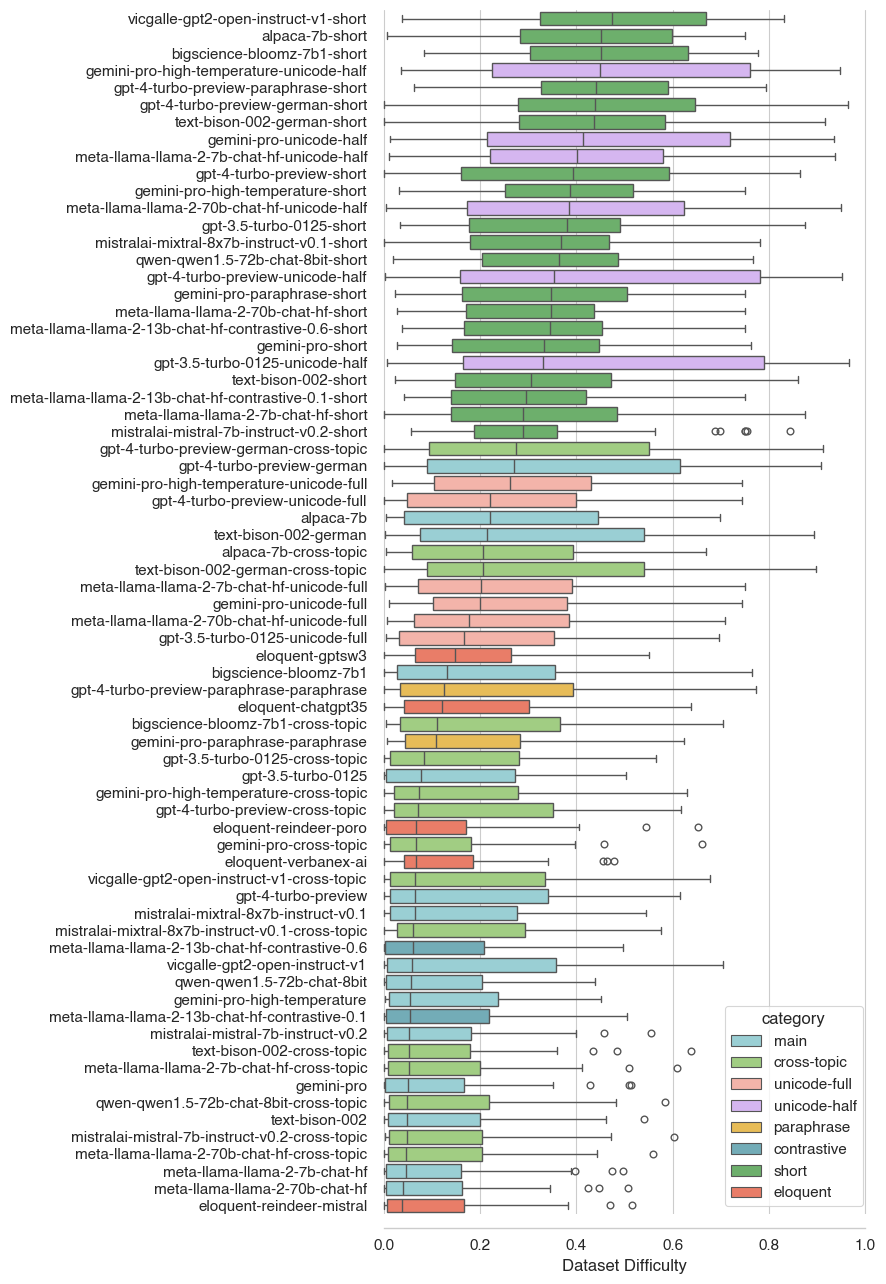

In [18]:
sort_order = df.groupby('dataset').median().sort_values('mean').index
plt.figure(figsize=(9, 13))
sns.boxplot(data=(1 - df), y='dataset', x='mean', hue='category', order=sort_order).set(
    xlabel='Dataset Difficulty', ylabel=None, xlim=(-.01, 1.01))
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-difficulty.pdf')
plt.show()

In [19]:
df_system_mean_adjusted = (df_system_mean - 0.5 * df_system_std).clip(0)
df_system_mean_adjusted = df_system_mean_adjusted.sort_values('mean', ascending=False)
df_system_mean_adjusted.to_csv('../data/eval-figures/system-effectiveness-adjusted.csv')

df_system_mean_adjusted.reset_index()[['team', 'mean']].to_latex(open('../data/eval-figures/system-effectiveness-adjusted.tex', 'w'), float_format='%.3f', index=False)
df_system_mean_adjusted.reset_index().to_html(open('../data/eval-figures/system-effectiveness-adjusted.html', 'w'), float_format='%.3f', index=False)

print('System effectiveness (corrected):')
df_system_mean_adjusted

System effectiveness (corrected):


,,roc-auc,brier,c@1,f1,f05u,mean
team,system,,,,,,
marsan,staff-trunk,0.961115,0.927702,0.912309,0.883747,0.931950,0.924070
you-shun-you-de,charitable-mole_v3,0.930615,0.925645,0.927658,0.904977,0.913460,0.921331
baselineavengers,svm,0.925399,0.868524,0.882245,0.875389,0.868994,0.885599
g-fosunlpteam,gritty-producer,0.888620,0.875107,0.886762,0.883613,0.883807,0.884411
lam,blistering-moss,0.851140,0.850302,0.850302,0.851763,0.848502,0.850708
drocks,muffled-stock,0.865790,0.863063,0.834464,0.824651,0.820192,0.842901
aida,corporate-burn,0.830889,0.825426,0.794835,0.788064,0.782064,0.806248
cnlp-nits-pp,direct-velocity,0.844403,0.793164,0.805228,0.789444,0.791814,0.805787
fosu-stu,proud-stick,0.833296,0.866540,0.799349,0.747740,0.767100,0.803728


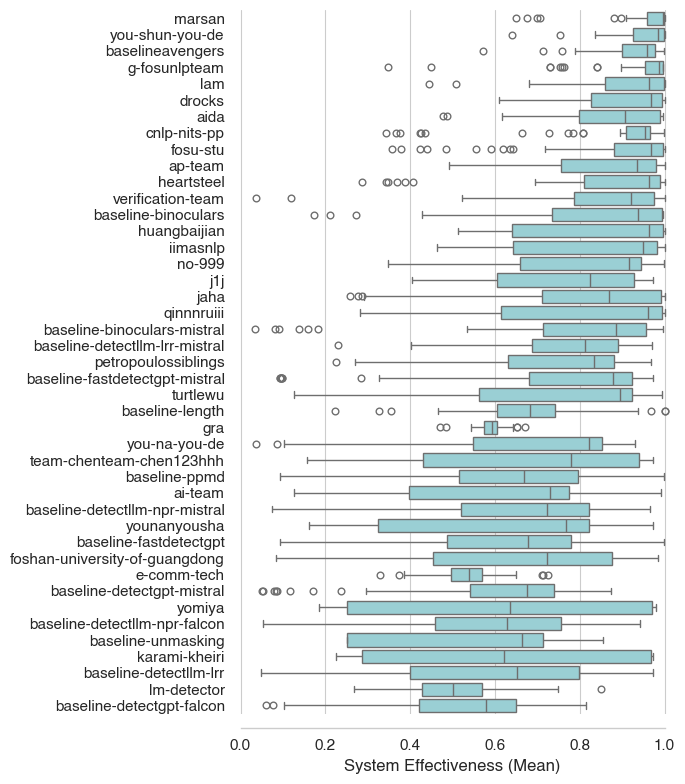

In [20]:
plt.figure(figsize=(7, 8))
sns.boxplot(data=df, y='team', x='mean', order=df_system_mean_adjusted.reset_index()['team']).set(
    xlabel='System Effectiveness (Mean)', ylabel=None, xlim=(-.01, 1.01))
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/team-effectiveness.pdf')
plt.show()

### Dataset Difficulty

In [21]:
df_ds_mean = (1 - df).groupby('dataset').mean().sort_values('mean', ascending=False)
df_ds_mean.to_csv('../data/eval-figures/eloquent-effectiveness.csv')
df_ds_mean

,roc-auc,brier,c@1,f1,f05u,mean
dataset,,,,,,
gemini-pro-high-temperature-unicode-half,0.472667,0.384357,0.503643,0.541929,0.550262,0.490524
vicgalle-gpt2-open-instruct-v1-short,0.410024,0.326024,0.439286,0.589000,0.607357,0.474262
bigscience-bloomz-7b1-short,0.435857,0.354119,0.476548,0.533190,0.523238,0.464571
gemini-pro-unicode-half,0.452071,0.371714,0.485310,0.481095,0.463881,0.450762
gpt-4-turbo-preview-german-short,0.409000,0.343429,0.473810,0.504595,0.483095,0.442786
...,...,...,...,...,...,...
text-bison-002,0.104930,0.109442,0.122209,0.122372,0.112395,0.114279
mistralai-mistral-7b-instruct-v0.2,0.101581,0.108488,0.118930,0.120233,0.117023,0.113209
meta-llama-llama-2-70b-chat-hf,0.095279,0.103023,0.111814,0.122977,0.117884,0.110209


In [22]:
top_idx = df_system_mean_adjusted.iloc[:10].index

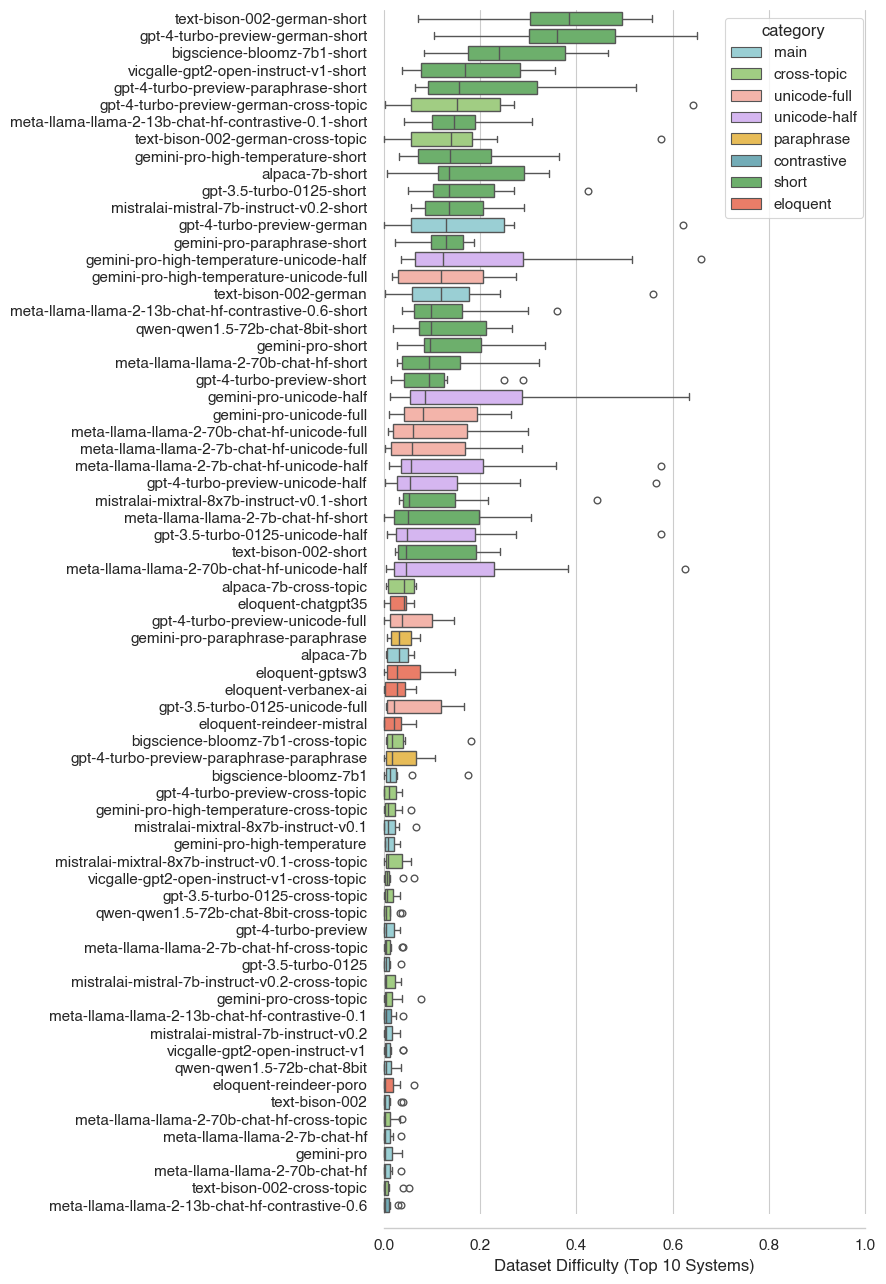

In [23]:
dataset_difficulty_top = (1 - df).loc[top_idx.get_level_values(0), top_idx.get_level_values(1), :, :]
sort_order = dataset_difficulty_top.groupby('dataset').median().sort_values('mean', ascending=False).index

plt.figure(figsize=(9, 13))
sns.boxplot(data=dataset_difficulty_top, y='dataset', x='mean', hue='category', order=sort_order).set(
    xlabel='Dataset Difficulty (Top 10 Systems)', ylabel=None, xlim=(-.01, 1.01))
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-difficulty-top.pdf')
plt.show()

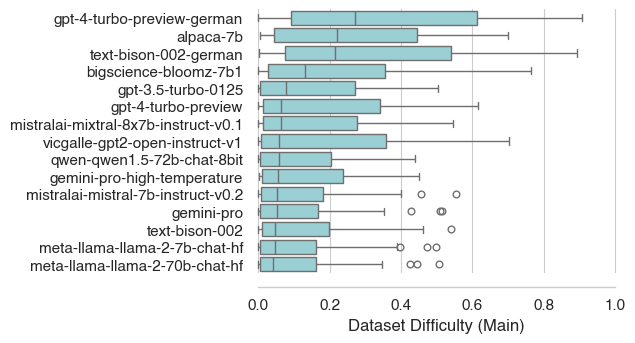

In [24]:
dataset_difficulty_main = (1 - df).query('category == "main"')
sort_order = dataset_difficulty_main.groupby('dataset').median().sort_values('mean', ascending=False).index

plt.figure(figsize=(6.5, 3.6))
sns.boxplot(data=dataset_difficulty_main, y='dataset', x='mean', order=sort_order).set(
    xlabel='Dataset Difficulty (Main)', ylabel=None, xlim=(-.01, 1.01))
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-difficulty-main.pdf')
plt.show()

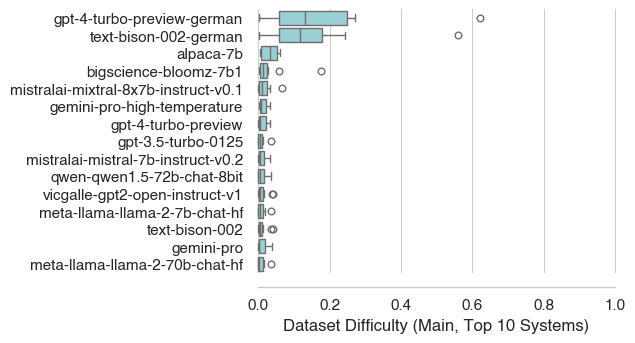

In [25]:
dataset_difficulty_main_top = dataset_difficulty_main.loc[top_idx.get_level_values(0), top_idx.get_level_values(1), :, :]
sort_order = dataset_difficulty_main_top.groupby('dataset').median().sort_values('mean', ascending=False).index

plt.figure(figsize=(6.5, 3.6))
sns.boxplot(data=dataset_difficulty_main_top, y='dataset', x='mean', order=sort_order).set(
    xlabel='Dataset Difficulty (Main, Top 10 Systems)', ylabel=None, xlim=(-.01, 1.01))
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-difficulty-main-top.pdf')
plt.show()

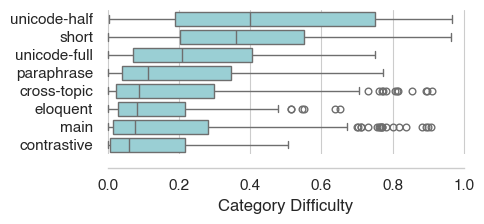

In [26]:
sort_order = df.groupby('category').median().sort_values('mean').index
plt.figure(figsize=(5, 2.4))
sns.boxplot(data=(1 - df), y='category', x='mean', order=sort_order).set(
    xlabel='Category Difficulty', ylabel=None, xlim=(-.01, 1.01))
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-category-difficulty.pdf')
plt.show()

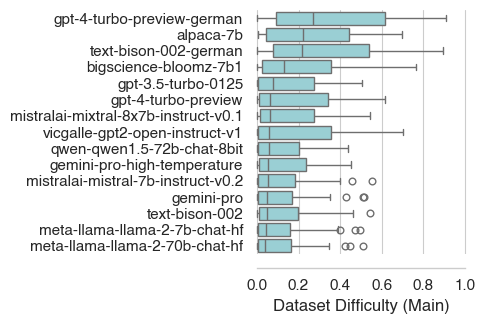

In [27]:
dataset_difficulty_main = (1 - df).query('category == "main"')
sort_order = dataset_difficulty_main.groupby('dataset').median().sort_values('mean', ascending=False).index

plt.figure(figsize=(5, 3.4))
sns.boxplot(data=dataset_difficulty_main, y='dataset', x='mean', order=sort_order).set(
    xlabel='Dataset Difficulty (Main)', ylabel=None, xlim=(-.01, 1.01))
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-difficulty-main.pdf')
plt.show()

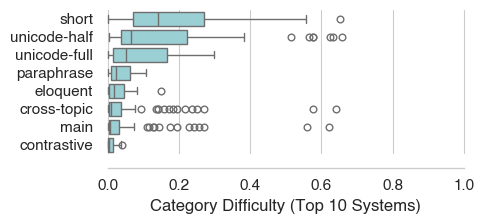

In [28]:
df_top = (1 - df).loc[top_idx.get_level_values(0), top_idx.get_level_values(1), :, :]
sort_order = df_top.groupby('category').median().sort_values('mean', ascending=False).index

plt.figure(figsize=(5, 2.4))
sns.boxplot(data=df_top, y='category', x='mean', order=sort_order).set(
    xlabel='Category Difficulty (Top 10 Systems)', ylabel=None, xlim=(-.01, 1.01))
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/dataset-category-difficulty-top.pdf')
plt.show()

### ELOQUENT Breaker Effectiveness

In [29]:
df_eloquent_ds = 1 - df.loc[:, :, 'eloquent']

df_eloquent = df_eloquent_ds.sort_values('mean', ascending=False)
df_eloquent.to_csv('../data/eval-figures/eloquent-effectiveness.csv')
df_eloquent

roc-auc  \
team                   system                 dataset                              
lm-detector            detector               eloquent-reindeer-poro       0.583   
baseline-detectllm-lrr baseline-detectllm-lrr eloquent-chatgpt35           0.629   
lm-detector            detector               eloquent-gptsw3              0.461   
e-comm-tech            great-plan             eloquent-reindeer-poro       0.476   
                                              eloquent-reindeer-mistral    0.465   
...                                                                          ...   
drocks                 muffled-stock          eloquent-reindeer-mistral    0.000   
ap-team                marinated-pantone      eloquent-verbanex-ai         0.000   
                                              eloquent-reindeer-poro       0.000   
                                              eloquent-reindeer-mistral    0.000   
marsan                 staff-trunk            eloquent-chatgpt35           0.000   

                                                                         brier  \
team                   system                 dataset                            
lm-detector            detector               eloquent-reindeer-poro     0.469   
baseline-detectllm-lrr baseline-detectllm-lrr eloquent-chatgpt35         0.356   
lm-detector            detector               eloquent-gptsw3            0.385   
e-comm-tech            great-plan             eloquent-reindeer-poro     0.323   
                                              eloquent-reindeer-mistral  0.314   
...                                                                        ...   
drocks                 muffled-stock          eloquent-reindeer-mistral  0.001   
ap-team                marinated-pantone      eloquent-verbanex-ai       0.000   
                                              eloquent-reindeer-poro     0.000   
                                              eloquent-reindeer-mistral  0.000   
marsan                 staff-trunk            eloquent-chatgpt35         0.001   

                                                                           c@1  \
team                   system                 dataset                            
lm-detector            detector               eloquent-reindeer-poro     0.656   
baseline-detectllm-lrr baseline-detectllm-lrr eloquent-chatgpt35         0.708   
lm-detector            detector               eloquent-gptsw3            0.542   
e-comm-tech            great-plan             eloquent-reindeer-poro     0.625   
                                              eloquent-reindeer-mistral  0.566   
...                                                                        ...   
drocks                 muffled-stock          eloquent-reindeer-mistral  0.000   
ap-team                marinated-pantone      eloquent-verbanex-ai       0.000   
                                              eloquent-reindeer-poro     0.000   
                                              eloquent-reindeer-mistral  0.000   
marsan                 staff-trunk            eloquent-chatgpt35         0.000   

                                                                            f1  \
team                   system                 dataset                            
lm-detector            detector               eloquent-reindeer-poro     0.789   
baseline-detectllm-lrr baseline-detectllm-lrr eloquent-chatgpt35         0.739   
lm-detector            detector               eloquent-gptsw3            0.714   
e-comm-tech            great-plan             eloquent-reindeer-poro     0.652   
                                              eloquent-reindeer-mistral  0.636   
...                                                                        ...   
drocks                 muffled-stock          eloquent-reindeer-mistral  0.000   
ap-team                marinated-pantone      eloquent-verbanex-ai       0.000   
                          

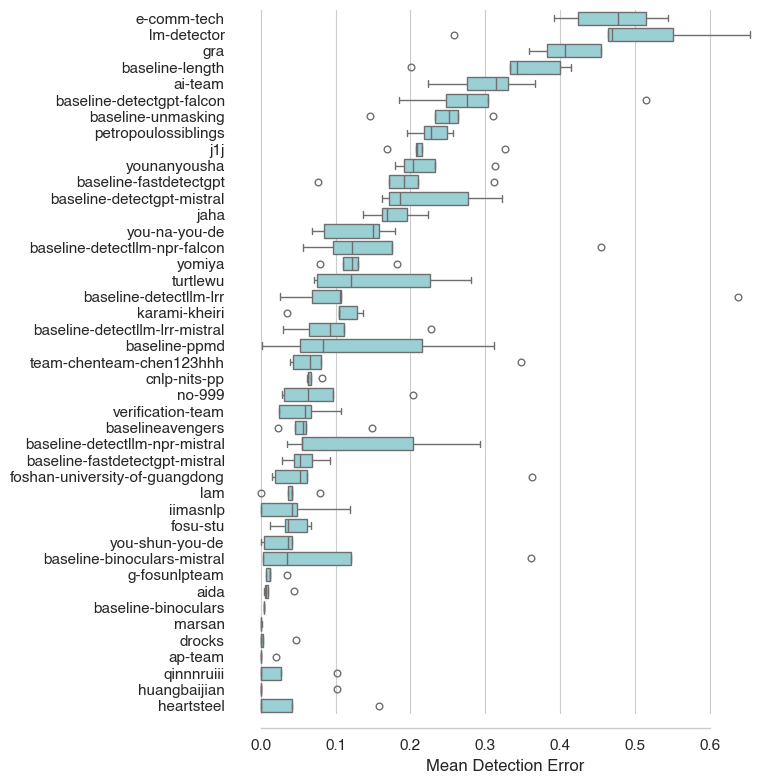

In [33]:
sort_order = df_eloquent_ds.groupby('team').median().sort_values('mean', ascending=False).index

plt.figure(figsize=(8, 8))
sns.boxplot(data=df_eloquent_ds, y='team', x='mean', order=sort_order).set(xlabel='Mean Detection Error', ylabel=None)
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/eloquent-system-effectiveness.pdf')
plt.show()

In [31]:
df_eloquent_mean = df_eloquent_ds.groupby('dataset').mean().sort_values('mean', ascending=False)
df_eloquent_mean.to_csv('../data/eval-figures/eloquent-effectiveness-mean.csv')
df_eloquent_mean

,roc-auc,brier,c@1,f1,f05u,mean
dataset,,,,,,
eloquent-chatgpt35,0.149628,0.147884,0.189791,0.205698,0.218512,0.182326
eloquent-gptsw3,0.152209,0.162395,0.185814,0.188209,0.162256,0.170209
eloquent-verbanex-ai,0.100186,0.115372,0.123651,0.145953,0.142674,0.125558
eloquent-reindeer-poro,0.108419,0.113814,0.117791,0.124302,0.125977,0.118093
eloquent-reindeer-mistral,0.096767,0.105140,0.103721,0.104093,0.099349,0.101791


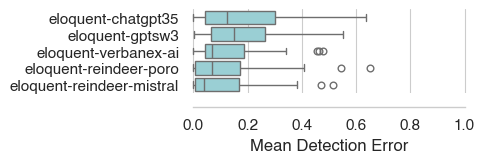

In [37]:
plt.figure(figsize=(5, 1.8))
sns.boxplot(data=df_eloquent_ds, y='dataset', x='mean', order=df_eloquent_mean.index).set(
    xlabel='Mean Detection Error', ylabel=None, xlim=(-0.01, 1.01))
sns.despine(left=True, offset=10, trim=True)
plt.tight_layout()
plt.savefig('../data/eval-figures/eloquent-effectiveness.pdf')
plt.show()